# Predictive Maintenance using Machine Learning on Sagemaker
*Part 5 - Getting predictions*

## Initialization
---
Directory structure to run this notebook:
```
nasa-turbofan-rul-lstm
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
|
+--- src: the inference code will be located in this directory
```
### Imports

In [14]:
%load_ext autoreload
import os
import errno
import sys
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
sns.set_style('darkgrid')
figures = []

INTERIM_DATA = '../data/interim'
PROCESSED_DATA = '../data/processed'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing utility tools:

In [15]:
%autoreload 2
sys.path.append('../src')
import nasa_rul_inference
import lstm_utils

Importing Sagemaker & AWS specific libraries: we also obtain the IAM role arn used to give training and hosting access to your data. Here we use the get_execution_role function to obtain the role arn which was specified when creating the notebook. We also configure the container image to be used for the region that we are running in.

In [16]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

sagemaker_session = sagemaker.Session()
role = get_execution_role()

### Loading data from the previous notebook

In [17]:
# Load data from the notebook local storage:
%store -r job_name
%store -r test_sequences
%store -r test_labels
%store -r unit_span
%store -r labels_scaler

# If the data are not present in the notebook local storage, we need to load them from disk:
success_msg = 'Loaded "job_name"'
if 'job_name' not in locals():
    try:
        local_path = '../data/processed'
        with open(os.path.join(local_path, 'job_name.txt'), 'r') as f:
            job_name = f.readline()
            
        print(success_msg + ': ' + job_name)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('Job name not found, you need to execute the training notebook')
            
else:
    print(success_msg + ': ' + job_name)
    
success_msg = 'Loaded "test_sequences" and "test_labels"'
if 'test_sequences' not in locals():
    import h5py as h5
    path = '../data/processed'
    test_data = os.path.join(path, 'test.h5')
    with h5.File(test_data, 'r') as ftest:
        test_sequences = ftest['test_sequences'][()]
        test_labels = ftest['test_labels'][()]
        
    ftest.close()
    
    print(success_msg)
    
else:
    print(success_msg)
    
success_msg = 'Loaded "unit_span"'
if 'unit_span' not in locals():
    with open(os.path.join(PROCESSED_DATA, 'unit_span.lst'), 'r') as f:
        unit_span = eval(f.readline())
        
    print('Loading unit_span from disk:')
    print(success_msg)
    
else:
    print('Variable unit_span found in notebook environment:')
    print(success_msg)
    
success_msg = 'Loaded "labels_scaler"'
if 'labels_scaler' not in locals():
    labels_scaler = joblib.load(os.path.join(PROCESSED_DATA, 'labels_scaler.joblib'))
        
    print('Loading labels_scaler from disk:')
    print(success_msg)
    
else:
    print('Variable labels_scaler found in notebook environment:')
    print(success_msg)

Loaded "job_name": nasa-rul-lstm-2020-06-16-09-12-37-314
Loaded "test_sequences" and "test_labels"
Variable unit_span found in notebook environment:
Loaded "unit_span"
Variable labels_scaler found in notebook environment:
Loaded "labels_scaler"


## Testing the inference code locally
---
The following cell is useful to test the inference code locally. It performs the same suite of actions than what an `Endpoint Invoke` API call will do:

In [5]:
payload = str(bytearray(test_sequences[:10]))
request_content_type = 'application/json'
response_content_type = 'application/json'

# Deserialize the Invoke request body into an object we can perform prediction on
input_object = nasa_rul_inference.input_fn(payload, request_content_type)

# Perform prediction on the deserialized object, with the loaded model
net = nasa_rul_inference.model_fn(model_dir = '../models')
prediction = nasa_rul_inference.predict_fn(input_object, net)

# Serialize the prediction result into the desired response content type
ouput = nasa_rul_inference.output_fn(prediction, response_content_type)

eval(ouput)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1454: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


[0.8844415,
 0.86312723,
 0.96013844,
 0.92866087,
 0.9490082,
 0.93776035,
 0.9122077,
 0.82505643,
 0.8698412,
 0.9095595]

## Predicting results
---
### Create a SageMaker endpoint and predictor
Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint. Before doing that, we need to locate the training artifacts that was generated during at training time:

In [18]:
sm_client = boto3.client('sagemaker')
training_job_description = sm_client.describe_training_job(TrainingJobName=job_name)
model_artifacts = training_job_description['ModelArtifacts']['S3ModelArtifacts']
model_artifacts

's3://sagemaker-eu-west-1-123031033346/nasa-rul-lstm/artifacts/nasa-rul-lstm-2020-06-16-09-12-37-314/output/model.tar.gz'

Then we can create a model with these artifacts and the inference code that will be used to serve the model results:

In [19]:
from sagemaker.mxnet import MXNetModel

mxnet_model = MXNetModel(
    model_data=model_artifacts,
    role=role,
    entry_point='../src/nasa_rul_inference.py',
    py_version='py3',
    framework_version='1.6.0'
)

Finally, we can deploy our model behind a SageMaker endpoint:

In [20]:
print('Creating endpoint to serve the model built with this training job: {}'.format(job_name))
predictor = mxnet_model.deploy(
    instance_type='ml.m4.xlarge',
    #instance_type='local',
    initial_instance_count=1
)
predictor.serializer = None
predictor.deserializer = None

Creating endpoint to serve the model built with this training job: nasa-rul-lstm-2020-06-16-09-12-37-314
-------------!

Let's test it:

In [21]:
payload = str(bytearray(test_sequences[:5]))
endpoint_name = predictor.endpoint

# If you already have an endpoint up and running, you can 
# uncomment the following line and replace "endpoint_id" 
# with the SageMaker ID of your endpoint:
#endpoint_name = 'endpoint_id'

sm_runtime_client = boto3.client('sagemaker-runtime')
response = sm_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType='application/json'
)
results = eval(response['Body'].read().decode('utf-8'))
results

[0.96442425, 0.97176206, 0.94808954, 0.95640975, 0.9864847]

## Getting and plotting results
---

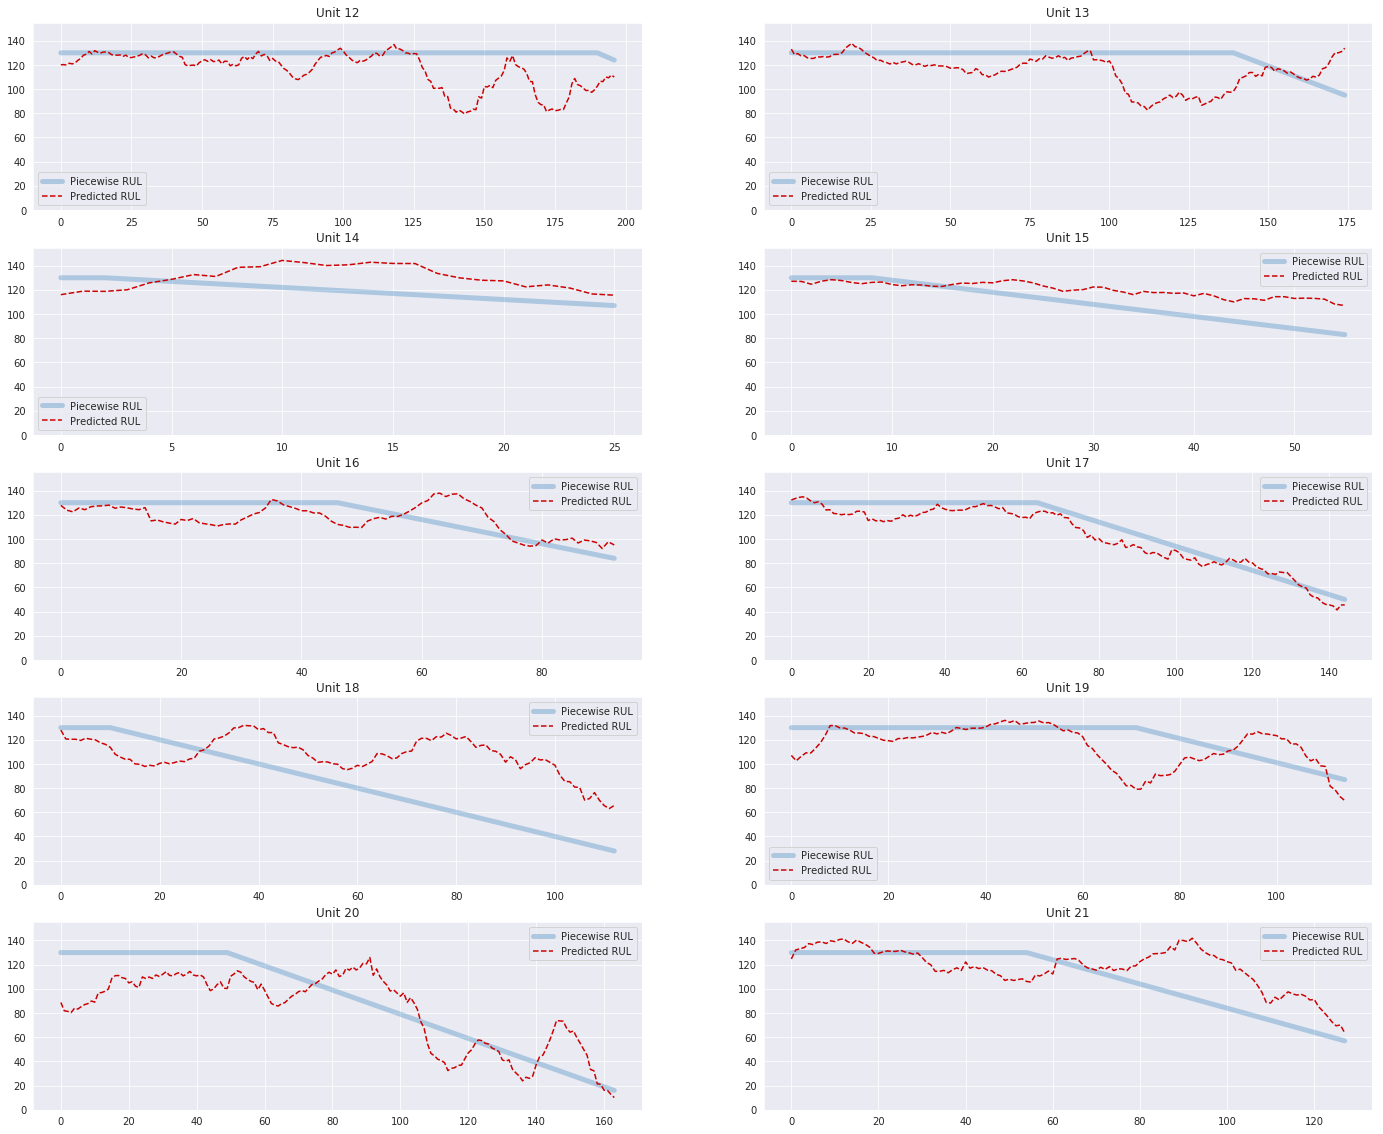

In [29]:
figure = plt.figure(figsize=(24,20))
figures.append(figure)

index = 1
for unit in range(12, 22):
    plt.subplot(5, 2, index)
    index += 1
    ax = lstm_utils.plot_unit_rul(test_sequences, test_labels, endpoint_name, labels_scaler, unit_span, unit, 'Unit {}'.format(unit))
    
    # Sleeping to prevent endpoint throttling:
    time.sleep(0.5)

In [25]:
sm_runtime_client = boto3.client('sagemaker-runtime')
df = pd.DataFrame()

for unit in range(1, 101):
    nb_sequences = unit_span[unit - 1]
    start = sum(unit_span[:unit - 1])
    end = start + nb_sequences
    unit_sequences = test_sequences[start:end]
    unit_rul = test_labels[start:end]
    
    if (unit_rul.shape[0] == 0):
        continue
    
    last_sequence = test_sequences[end - 1]
    ground_truth_rul = labels_scaler.inverse_transform(test_labels[end - 1].reshape(-1, 1))[0][0]
    
    payload = str(bytearray(last_sequence))
    response = sm_runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=payload,
        ContentType='application/json'
    )
    results = eval(response['Body'].read().decode('utf-8'))
    predicted_rul = round(labels_scaler.inverse_transform(np.array(results).reshape(-1, 1))[0][0], 1)
    
    s = pd.Series({'Real RUL': ground_truth_rul, 'Predicted RUL': predicted_rul})
    s.name = unit
    df = df.append(s)

import math
squared_error = (df['Predicted RUL'] - df['Real RUL'])**2
RMSE = round(math.sqrt(squared_error.mean()), 0)
df

,Predicted RUL,Real RUL
2,140.9,98.0
3,31.4,69.0
4,59.3,82.0
5,85.6,91.0
6,115.2,93.0
...,...,...
96,119.5,130.0
97,94.6,82.0
98,100.6,59.0
99,131.4,117.0


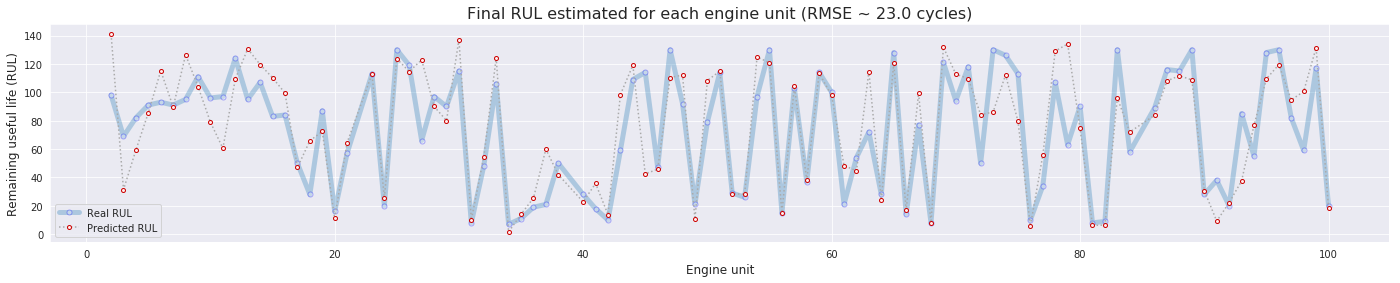

In [27]:
figure = plt.figure(figsize=(24,4))
figures.append(figure)
ax = df['Real RUL'].plot(linestyle='-', linewidth=5, alpha=0.3, label='Real RUL', marker='.', markerfacecolor='#FFFFFF', markeredgecolor='#0000FF', markersize=10)
df['Predicted RUL'].plot(linestyle=':', color='#AAAAAA', ax=ax, label='Predicted RUL', marker='o', markerfacecolor='#FFEEEE', markeredgecolor='#CC0000', markersize=4)
ytitle = ax.set_ylabel('Remaining useful life (RUL)', fontsize=12)
xtitle = ax.set_xlabel('Engine unit', fontsize=12)
plt.legend()
plot_title = plt.title('Final RUL estimated for each engine unit (RMSE ~ {} cycles)'.format(RMSE), fontsize=16)

## Cleanup
---

In [13]:
sagemaker_session.delete_endpoint(endpoint_name)

for fig in figures:
    fig.clear()
    plt.close(fig)

import gc
_ = gc.collect()